In [321]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [322]:
df = pd.read_csv('data/fake_news.csv', parse_dates=['timestamp'])

(sec:fake_news_exploring)=
# Exploring the Data

The dataset of news articles we're exploring is just one part of the larger FakeNewsNet dataset. As such, the original paper doesn't provide detailed information about our subset of data.
So, to better understand the data, we must explore it ourselves.

Before starting exploratory data analysis, we apply our standard practice of splitting the data into training and test sets. We perform EDA using only the train set:

In [323]:
from sklearn.model_selection import train_test_split

df['label'] = (df['label'] == 'fake').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

In [324]:
X_train.head(2)

,timestamp,baseurl,content
164,2019-01-04 19:25:46,worldnewsdailyreport.com,Chinese lunar rover finds no evidence of Ameri...
28,2016-01-12 21:02:28,occupydemocrats.com,Virginia Republican Wants Schools To Check Chi...


Let's count the number of real and fake articles in the train set: 

In [325]:
y_train.value_counts()

label
0    320
1    264
Name: count, dtype: int64

Our train set has 584 articles, and there are about 60 more articles labeled as `real` compared to `fake`. Next, we check for missing values in the three fields:

In [326]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 164 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  306 non-null    datetime64[ns]
 1   baseurl    584 non-null    object        
 2   content    584 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ KB


Nearly half of the timestamps are null. This feature will limit the dataset if we use it in the analysis. Let's take a closer look at the `baseurl`, which represents the website that published the original article.

## Exploring the Publishers

To understand the `baseurl` column, we start by counting the number of articles from each website:

In [327]:
X_train['baseurl'].value_counts()

baseurl
whitehouse.gov               21
abcnews.go.com               20
nytimes.com                  17
                             ..
occupydemocrats.com           1
legis.state.ak.us             1
dailynewsforamericans.com     1
Name: count, Length: 337, dtype: int64

Our train set has 584 rows, and we have found that there are 337 unique publishing websites. This means that the dataset includes many publications with only a few articles. A histogram of the number of articles published by each website confirms this:

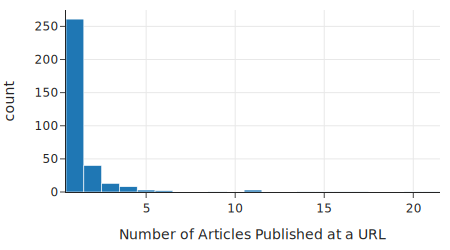

In [328]:
fig=px.histogram(X_train['baseurl'].value_counts(), width=450, height=250,
            labels={"value":"Number of Articles Published at a URL"})

fig.update_layout(showlegend=False)

This histogram shows that the vast majority (261 out of 337) of websites have only one article in the train set, and only a few websites have more than five articles in the train set.
Nonetheless, it can be informative to identify the websites that published the most fake or real articles. First, we find the websites that published the most fake articles:

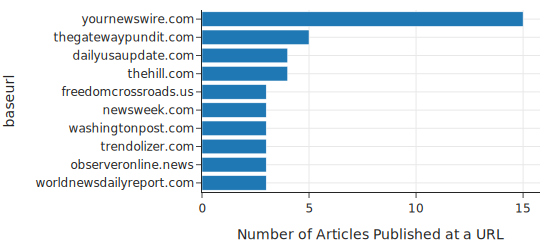

In [329]:
top_fake_publishers = (
    X_train.assign(label=y_train)
    .query("label == 1")
    ["baseurl"]
    .value_counts()
    .iloc[:10]
    .sort_values()
)

fig = px.bar(
    top_fake_publishers,
    orientation="h", width=550, height=250,
    labels={"value": "Number of Articles Published at a URL", "index": ""},
)
fig.update_layout(showlegend=False)

Next, we list the websites that published the greatest number of real articles:

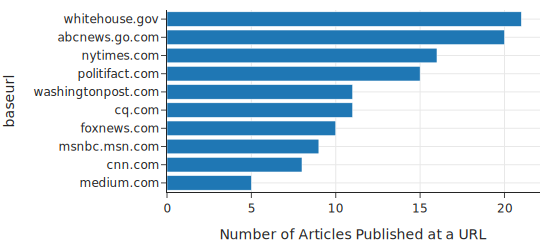

In [330]:
top_real_publishers = (
    X_train.assign(label=y_train)
    .query("label == 0")
    ["baseurl"]
    .value_counts()
    .iloc[:10]
    .sort_values()
)

fig = px.bar(
    top_real_publishers,
    orientation="h", width=550, height=250,
    labels={"value": "Number of Articles Published at a URL", "index": ""},
)
fig.update_layout(showlegend=False)

Only `cnn.com` appears on both lists. Even without knowing the total number of articles for these sites, we might expect that an article from `yournewswire.com` is more likely to be labeled as `fake`, while an article from `whitehouse.gov` is more likely to be labeled as `real`. That said, we don't expect that using the publishing website to predict article truthfulness would work very well; there are simply too few articles from most of the websites in the dataset.

Next, let's explore the `timestamp` column, which records the publication date of the news articles.

## Exploring Publication Date

Plotting the timestamps on a histogram shows that most articles were published after 2000, although there seems to be at least one article published before 1940:

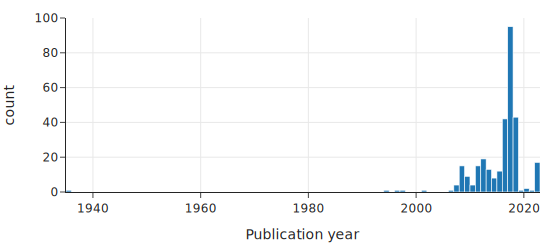

In [331]:
fig = px.histogram(
    X_train["timestamp"],
    labels={"value": "Publication year"}, width=550, height=250,
)
fig.update_layout(showlegend=False)

When we take a closer look at the new articles published prior to 2000, we find that the timestamps don't match the actual publication date of the article. These date issues are most likely related to the web scraper collecting inaccurate information from the web pages. We can zoom into the region of the histogram after 2000:

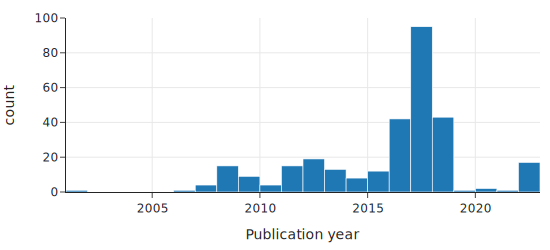

In [332]:
fig = px.histogram(
    X_train.loc[X_train["timestamp"] > "2000", "timestamp"],
    labels={"value": "Publication year"}, width=550, height=250, 
)
fig.update_layout(showlegend=False)

As expected, most of the articles were published between 2007 (the year Politifact was founded) and 2020 (the year the FakeNewsNet repository was published). But we also find that the timestamps are concentrated on the years 2016 to 2018—the year of the controversial 2016 US presidential election and the two years following. This insight is a further caution on the limitation of our analysis to carry over to nonelection years. 

Our main aim is to use the text content for classification. We explore some word frequencies next.

## Exploring Words in Articles

We'd like to see whether there's a relationship between the words used in the articles and whether the article was labeled as `fake`. One simple way to do this is to look at individual words like _military_, then count how many articles that mentioned "military" were labeled `fake`. For _military_ to be useful, the articles that mention it should have a much higher or much lower fraction of fake  articles than 45% (the proportion of fake articles in the dataset: 264/584). 

We can use our domain knowledge of political topics to pick out a few candidate words to explore:

In [335]:
word_features = [
    # names of presidential candidates
    'trump', 'clinton',
    #congress words
    'state', 'vote', 'congress', 'shutdown',
    
    # other possibly useful words
    'military', 'princ', 'investig', 'antifa', 
    'joke', 'homeless', 'swamp', 'cnn', 'the'
]

Then we define a function that creates a new feature for each word, where the feature contains `True` if the word appeared in the article and `False` if not: 

In [336]:
def make_word_features(df, words):
    features = { word: df['content'].str.contains(word) for word in words }
    return pd.DataFrame(features)

This is like one-hot encoding for the presence of a word (see {numref}`Chapter %s <ch:linear>`). We can use this function to further wrangle our data and create a new data frame with a feature for each of our chosen words:  

In [337]:
df_words = make_word_features(X_train, word_features)
df_words["label"] = df["label"]

In [338]:
df_words.shape

(584, 16)

In [339]:
df_words.head(4)

,trump,clinton,state,vote,...,swamp,cnn,the,label
164,False,False,True,False,...,False,False,True,1
28,False,False,False,False,...,False,False,True,1
708,False,False,True,True,...,False,False,True,0
193,False,False,False,False,...,False,False,True,1


Now we can find the proportion of these articles that were labeled `fake`. We visualize these calculations in the following plots. In the left plot, we mark the proportion of `fake` articles in the entire train set using a dotted line, which helps us understand how informative each word feature is—a highly informative word will have a point that lies far away from the line:

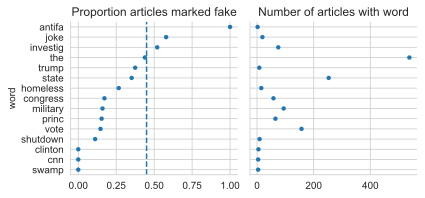

In [345]:
fake_props = (make_word_features(X_train, word_features)
 .assign(label=(y_train == 1))
 .melt(id_vars=['label'], var_name='word', value_name='appeared')
 .query('appeared == True')
 .groupby('word')
 ['label']
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'prop_fake'})
 .sort_values('prop_fake', ascending=False)
 .reset_index()
 .melt(id_vars='word')
)

g = sns.catplot(data=fake_props, x='value', y='word', col='variable',
                s=20, jitter=False, sharex=False, height=3)

[[prop_ax, _]] = g.axes
prop_ax.axvline(0.45, linestyle='--')
prop_ax.set(xlim=(-0.05, 1.05))

titles = ['Proportion articles marked fake', 'Number of articles with word']

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
    ax.set(xlabel=None)
    ax.yaxis.grid(True);

This plot reveals a few interesting considerations for modeling.
For example, notice that the word _antifa_ is highly predictive---all articles that mention the word _antifa_ are labeled `fake`. However, _antifa_ only appears in a few articles. On the other hand, the word _the_ appears in nearly every article, but is uninformative for distinguishing between `real` and `fake` articles because the proportion of articles with _the_ that are fake matches the proportion of fake articles overall. We might instead do better with a word like _vote_, which is predictive and appears in many news articles.

This exploratory analysis brought us understanding of the time frame that our news articles were published, the broad range of publishing websites captured in the data, and candidate words to use for prediction. Next, we fit models for predicting whether articles are fake or real.